In [ ]:
pip install qiskit

In [ ]:
pip install qiskit-aer-gpu-cu11

In [1]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.quantum_info import Statevector
from qiskit.quantum_info import DensityMatrix, Statevector, SparsePauliOp, Operator, partial_trace, entropy

from spin import *
from trotter import *
import time

In [20]:
simulator_gpu = AerSimulator(method='statevector', device='GPU')
print(simulator_gpu.available_devices())
print(simulator_gpu.available_methods())

['GPU']
('automatic', 'statevector', 'density_matrix', 'stabilizer', 'matrix_product_state', 'extended_stabilizer', 'unitary', 'superop', 'tensor_network')


In [74]:
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.synthesis import LieTrotter
import numpy as np

n = 8

QIMF = Nearest_Neighbour_1d(n, hx=0.8090, hy=0.9045, Jx=1, pbc=False)

H = QIMF.ham_xyz
print(H)

init = Statevector.from_label("101010101010")
t = 10
r = 100
m = 1
dt = (t / r)
dt2 = (t / (r*m))

print(dt, dt2)

[SparsePauliOp(['IIIIIIXX', 'IIIIIXXI', 'IIIIXXII', 'IIIXXIII', 'IIXXIIII', 'IXXIIIII', 'XXIIIIII', 'IIIIIIIX', 'IIIIIIXI', 'IIIIIXII', 'IIIIXIII', 'IIIXIIII', 'IIXIIIII', 'IXIIIIII', 'XIIIIIII'],
              coeffs=[1.   +0.j, 1.   +0.j, 1.   +0.j, 1.   +0.j, 1.   +0.j, 1.   +0.j,
 1.   +0.j, 0.809+0.j, 0.809+0.j, 0.809+0.j, 0.809+0.j, 0.809+0.j,
 0.809+0.j, 0.809+0.j, 0.809+0.j]), SparsePauliOp(['IIIIIIIY', 'IIIIIIYI', 'IIIIIYII', 'IIIIYIII', 'IIIYIIII', 'IIYIIIII', 'IYIIIIII', 'YIIIIIII'],
              coeffs=[0.9045+0.j, 0.9045+0.j, 0.9045+0.j, 0.9045+0.j, 0.9045+0.j, 0.9045+0.j,
 0.9045+0.j, 0.9045+0.j])]
0.1 0.1


In [ ]:
from qiskit.synthesis import SuzukiTrotter

trotter_step_first_order = PauliEvolutionGate(H, time=dt, synthesis=LieTrotter())
circ_pf1 = QuantumCircuit(n)

trotter_step_second_order = PauliEvolutionGate(H, time=dt2, synthesis=SuzukiTrotter())
circ_pf2 = QuantumCircuit(n)

start_time = time.time()
data, data2 = [], []
ideal_psi = init
total_steps = r*m - 1

for s in range(1, r+1):
  # circ_pf2 = circuit.copy()
  for ss in range (1, m+1):
    print("step:", ss)
    circ_pf2.append(trotter_step_second_order, range(n))
    circ_pf2 = circ_pf2.decompose(reps=2)
    circ_pf2.save_statevector(label=f"temp_{total_steps}")

    res2 = simulator_gpu.run(transpile(circ_pf2, simulator_gpu), initial_statevector=ideal_psi.data).result()
    temp = res2.data(0)[f"temp_{total_steps}"]
    ideal_psi = temp
    # print(f"temp_{ss}")
    total_steps -= 1

  ideal_psi = res2.data(0)[f"temp_{total_steps + 1}"]
  data2.append(ideal_psi)

  # circ2 = qc.copy()
  circ_pf1.append(trotter_step_first_order, range(n))
  circ_pf1.save_statevector(label=f"sv_{s}")

  circ_pf1 = circ_pf1.decompose(reps=2)
  res = simulator_gpu.run(transpile(circ_pf1, simulator_gpu), initial_statevector=ideal_psi.data).result()
  psi = res.data(0)[f"sv_{s}"]
  data.append(psi)

  print(np.linalg.norm(ideal_psi - psi))

  print("pf1 step:", s)

better_states = data2
states = data

total_time = time.time() - start_time
print("total time", total_time)

In [ ]:
circ_pf2.draw()

In [ ]:
entropy_list = []
entropy_list2 = []

for s in range(1, r+1):
    rdm1 = partial_trace(DensityMatrix(states[s-1]), list(range(1, n)))
    rdm2 = partial_trace(DensityMatrix(states[s-1]), list(range(2, n)))
    rdm3 = partial_trace(DensityMatrix(states[s-1]), list(range(3, n)))
    rdm4 = partial_trace(DensityMatrix(states[s-1]), list(range(4, n)))
    temp_entropy = [entropy(rdm1), entropy(rdm2), entropy(rdm3), entropy(rdm4)]
    print(s, temp_entropy)

    rdm12 = partial_trace(DensityMatrix(better_states[s-1]), list(range(1, n)))
    rdm22 = partial_trace(DensityMatrix(better_states[s-1]), list(range(2, n)))
    rdm32 = partial_trace(DensityMatrix(better_states[s-1]), list(range(3, n)))
    rdm42 = partial_trace(DensityMatrix(better_states[s-1]), list(range(4, n)))
    temp_entropy2 = [entropy(rdm12), entropy(rdm22), entropy(rdm32), entropy(rdm42)]
    print(temp_entropy2)

    entropy_list.append(temp_entropy)
    entropy_list2.append(temp_entropy2)

In [ ]:
trotter = []
for s in range(0, r):
  tro = np.linalg.norm(better_states[s] - states[s])
  print(tro)
  trotter.append(tro)

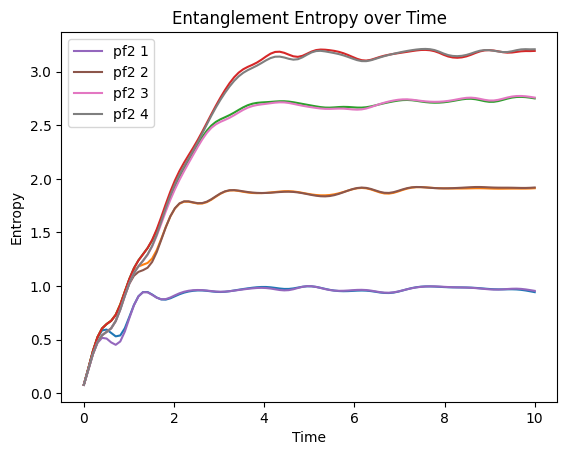

In [78]:
import matplotlib.pyplot as plt
import numpy as np

dt = 0.1
steps = len(entropy_list)
times = np.linspace(0, 10, 100)

# Extract the first element of each sublist in entropy_list
entropy_values_1 = [entropy[0] for entropy in entropy_list]
entropy_values_2 = [entropy[1] for entropy in entropy_list]
entropy_values_3 = [entropy[2] for entropy in entropy_list]
entropy_values_4 = [entropy[3] for entropy in entropy_list]


# Extract the first element of each sublist in entropy_list2
entropy_values_12 = [entropy[0] for entropy in entropy_list2]
entropy_values_22 = [entropy[1] for entropy in entropy_list2]
entropy_values_32 = [entropy[2] for entropy in entropy_list2]
entropy_values_42 = [entropy[3] for entropy in entropy_list2]

# Create the plot
plt.plot(times, entropy_values_1)
plt.plot(times, entropy_values_2)
plt.plot(times, entropy_values_3)
plt.plot(times, entropy_values_4)

plt.plot(times, entropy_values_12, label='pf2 1')
plt.plot(times, entropy_values_22, label='pf2 2')
plt.plot(times, entropy_values_32, label='pf2 3')
plt.plot(times, entropy_values_42, label='pf2 4')

plt.xlabel("Time")
plt.ylabel("Entropy")
plt.title("Entanglement Entropy over Time")
plt.legend()
plt.show()

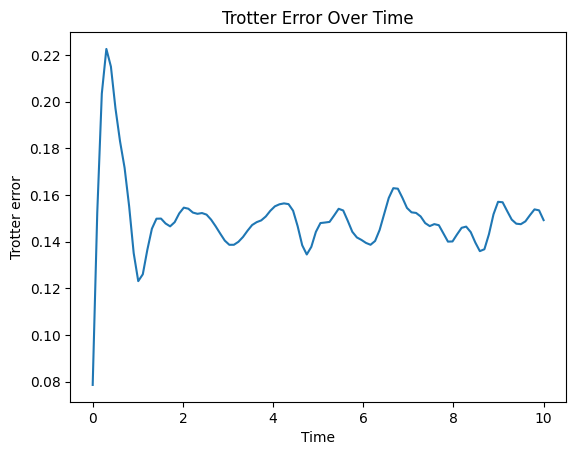

In [79]:
plt.plot(times, trotter)
plt.xlabel("Time")
plt.ylabel("Trotter error")
plt.title("Trotter Error Over Time")
plt.show()